# Libraries

In [14]:
import numpy as np
import pandas as pd
import time

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for importing images to arrays
import glob
from PIL import Image

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

# KNN
from sklearn import neighbors

# SVM
from sklearn.svm import SVC

# CNN
import tensorflow as tf

# Importing and preprocessing data

In [2]:
# Downloading the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
# flatten the array for KNN and SVM clustering
x_train_cl = x_train.mean(axis=3).reshape(60000,784)
x_test_cl = x_test.mean(axis=3).reshape(10000,784)

# retain shape but drop the color vector for CNN
x_train_tf = x_train.mean(3).reshape(60000,28,28,1)
x_test_tf = x_test.mean(3).reshape(10000,28,28,1)

print("Shape of training digit images for KNN and SVM:", x_train_cl.shape)
print("Shape of training digit images for CNN:", x_train_tf.shape)

Shape of training digit images for KNN and SVM: (60000, 784)
Shape of training digit images for CNN: (60000, 28, 28, 1)


In [15]:
# validating if the training datset is uniformly sampled
Counter(y_train)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

### Visualizing the digits

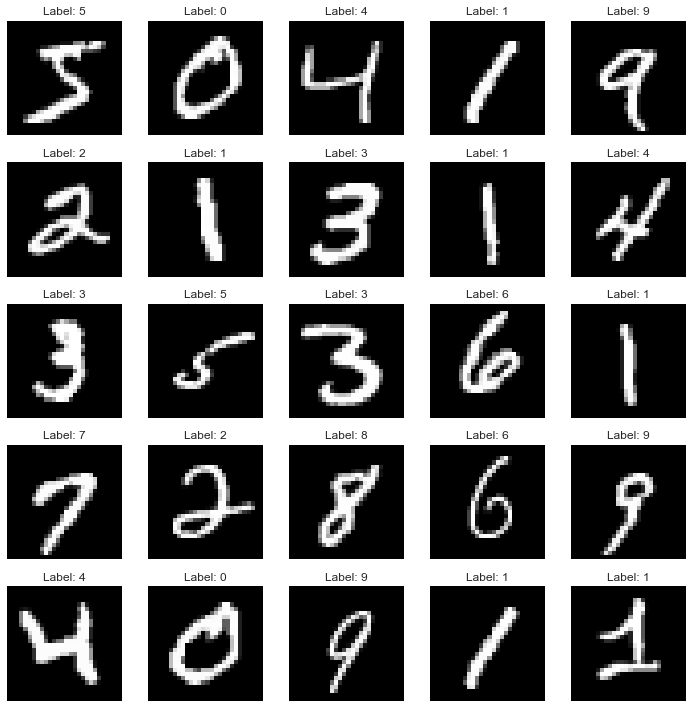

In [4]:
# function that displays a digit given its vector representation
def get_numberLabel(x, label):
    plt.axis('off')
    plt.imshow(x, cmap=plt.cm.gray)
    plt.title('Label: ' + str(label))
    
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    get_numberLabel(x_train[i,], y_train[i])
    
plt.tight_layout()
plt.show()

### Importing images with noise

In [5]:
# 9 image files
filelist = glob.glob('./images/*.jpg')

In [6]:
# converting to a single array with 9 rows
temp1 = np.array([np.array(Image.open(fname)) for fname in filelist])

# flatten the array for KNN and SVM clustering
my_numbers_cl = temp1.mean(axis=3).reshape(9,784)

# retain shape but drop the color vector for CNN
my_numbers_tf = temp1.mean(3).reshape(9,28,28,1)

print("Shape of my numbers images for KNN and SVM:", my_numbers_cl.shape)
print("Shape of my numbers images for CNN:", my_numbers_tf.shape)

Shape of my numbers images for KNN and SVM: (9, 784)
Shape of my numbers images for CNN: (9, 28, 28, 1)


In [7]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
my_numbers_cl /= 255.

my_numbers_tf /= 255.


In [8]:
# labels for my numbers
my_number_labels = np.int64(['8','9','4','5','7','6','2','3','1'])
my_number_labels

array([8, 9, 4, 5, 7, 6, 2, 3, 1])

### Visualizing new 'noisy' numbers

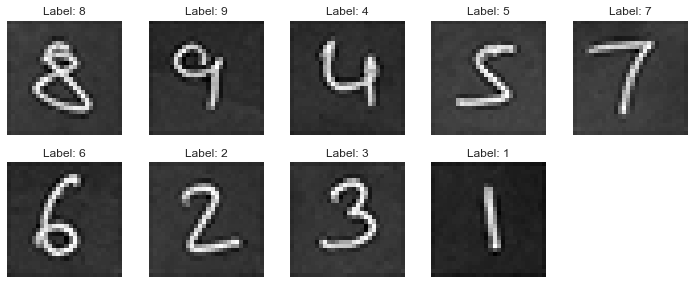

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(5,5, i+1)
    get_numberLabel(my_numbers_tf[i,], my_number_labels[i])
    
plt.tight_layout()
plt.show()

The numbers here are not exactly preprocessed like the actual dataset numbers. For example, the background color is not uniform and the digits are not necessarily center of image. This is precisely the reason why these iamges will stress test the models for accuracy. We can visualize the noise in these images by comparing the pixel values with the dataset image of same label - 

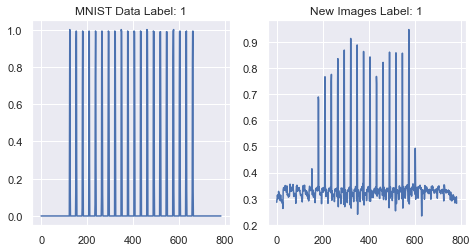

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.title('MNIST Data Label: ' + str(y_train[6]))
plt.plot(x_train_cl[6])
plt.subplot(3,3,2)
plt.title('New Images Label: ' + str(my_number_labels[8]))
plt.plot(my_numbers_cl[8])
plt.tight_layout()
plt.show()

# K-nearest neighbors (KNN) classifier

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree). <br> _- sklearn.neighbors user guide_ <br><br>
sklearn.neighbors package provides functionality for unsupervised and supervised neighbors-based learning methods. For MNIST classification, we will use simplest form of these methods with default values. 

In [17]:
## Build nearest neighbor structure on training data. Method neighbors.KNeighborsClassifier takes following parameters -
# n_neighbors int, default=5
# weights{‘uniform’, ‘distance’} or callable, default=’uniform’
# algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
# leaf_sizeint, default=30
# p int, default=2
# metric str or callable, default=’minkowski’
# metric_params dict, default=None
# n_jobs int, default=None
## We will only be using n_neighbors with value 3 and default value for other parameters. The default metric is minkowski, 
## and with p=2 is equivalent to the standard Euclidean metric.

t_before = time.time()
model_KNN = neighbors.KNeighborsClassifier(n_neighbors=3).fit(x_train_cl,y_train)
t_after = time.time()
## Compute training time
t_training_KNN = t_after - t_before
print("Time to build KNN neighbor classfier on training data (seconds): ", t_training_KNN)

Time to build KNN neighbor classfier on training data (seconds):  17.11131477355957


In [18]:
## Get nearest neighbor predictions on test data
t_before = time.time()
test_pred_KNN = model_KNN.predict(x_test_cl)
t_after = time.time()
## Compute testing time
t_testing_KNN = t_after - t_before
print("Time to classify test set (seconds): ", t_testing_KNN)

Time to classify test set (seconds):  699.6128578186035


### Evaluating the KNN classifier

In [19]:
# evaluate the classifier
accuracy_KNN = sum(test_pred_KNN == y_test) / float(len(y_test))
accuracy_KNN

0.9705

<AxesSubplot:>

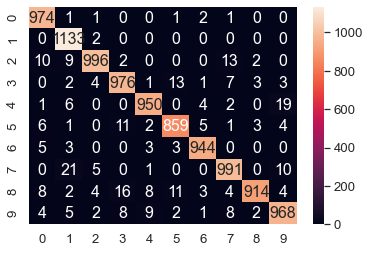

In [20]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test,test_pred_KNN)
df_cm = pd.DataFrame(cm, range(10), range(10))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d") 

In [21]:
# Testing the model on new 'noisy' digits
myNumbers_pred_KNN = model_KNN.predict(my_numbers_cl)
myNumbers_pred_KNN

array([8, 4, 4, 5, 1, 6, 2, 3, 1], dtype=uint8)

In [22]:
# accuracy predicting 'noisy' digits
N_accuracy_KNN = sum(myNumbers_pred_KNN == my_number_labels) / float(len(my_number_labels))
N_accuracy_KNN

0.7777777777777778

<AxesSubplot:>

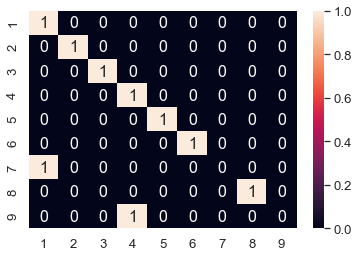

In [23]:
# Confusion matrix for my handwriting
cm = metrics.confusion_matrix(my_number_labels,myNumbers_pred_KNN)
df_cm = pd.DataFrame(cm, range(1,10,1),range(1,10,1))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d") 

In [35]:
# The model got 7 and 9 wrong. examining nearest neighbours for label 7: 
model_KNN.kneighbors([my_numbers_cl[4,]])

(array([[7.35304517, 7.36830963, 7.36978092]]), array([[49392, 40058, 21818]]))

In [37]:
print("Nearest neighbours for new digit image labeled 7 are: ", y_train[49392],y_train[40058],y_train[21818])

Nearest neighbours for new digit image labeled 7 are:  1 1 1


## Commentary on KNN classification of MNIST and additional images

- KNN classification figures out distance between two images by flattening the images as a one dimensional array of pixel values and calculating Squared Euclidean distance (among other ways) between two corresponding pixel values.
- Hence, although the model is effective in a simple case like this but would not be able to maintain accuracy in more complex image classifications since it does not account for 2nd dimension in images (specifically, how a pixel value is related with all the neighbouring pixels in an image).
- The training phase of KNN is just the storing of feature vectors and corresponding labels of training data. During testing, each test sample is classified by determining nearest k neighbours and their labels. Hence testing phase takes more computation and the time is proportional to the size of test sample.

# SVM Classification

SVM is a pretty complex binary classifier that uses quadratic programming to maximize the margin between the separating hyper-planes. The binary SVM classifier is extended to handle multi-class classification problems using the 1-vs-all or 1-vs-1 technique. We are going to use scikit-learn's implementation, SVC(), with polynomial kernel (of degree 2) to fit (train) the soft-margin (kernelized) SVM classifier with the training dataset and then predict the labels of the test images using the score() function.

In [39]:
t_before = time.time()
model_SVM = SVC(C=1, kernel='poly', degree=2)
model_SVM.fit(x_train_cl,y_train)
t_after = time.time()
## Compute training time
t_training_SVM = t_after - t_before
print("Time to classify train set (seconds): ", t_training_SVM)

Time to classify train set (seconds):  432.05135893821716


In [40]:
# determining accuracy using score function on test dataset
t_before = time.time()
accuracy_SVM = model_SVM.score(x_test_cl,y_test)
print(accuracy_SVM)
t_after = time.time()
## Compute testing time
t_testing_SVM = t_after - t_before
print("Time to classify test set (seconds): ", t_testing_SVM)

0.9774
Time to classify test set (seconds):  143.1475841999054


<AxesSubplot:>

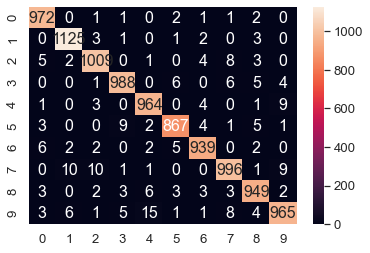

In [42]:
# Confusion matrix
test_predictions_SVM = model_SVM.predict(x_test_cl)
cm = metrics.confusion_matrix(y_test,test_predictions_SVM)
df_cm = pd.DataFrame(cm, range(10), range(10))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")

In [44]:
# Testing the model on new digit images
myNumbers_pred_SVM = model_SVM.predict(my_numbers_cl)
myNumbers_pred_SVM

array([5, 8, 8, 2, 8, 2, 2, 3, 8], dtype=uint8)

In [45]:
# accuracy predicting new digits
N_accuracy_SVM = sum(myNumbers_pred_SVM == my_number_labels) / float(len(my_number_labels))
N_accuracy_SVM

0.2222222222222222

<AxesSubplot:>

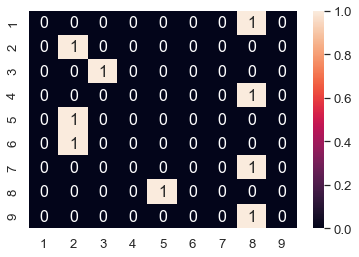

In [46]:
# Confusion matrix for my handwriting
cm = metrics.confusion_matrix(my_number_labels,myNumbers_pred_SVM)
df_cm = pd.DataFrame(cm, range(1,10,1),range(1,10,1))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d") 

## Commentary on SVM classification of MNIST and additional images

- SVM classification resulted in slightly better accuracy compared to KNN. This is expected given the cleanliness and simplicity of MNIST image dataset. 
- However, SVM fails when the data has noise and overlapping points. This happens because there is a problem in drawing a clear hyperplane without misclassifying.

# Convolutional Neural Network

CNNs are a subtype of deep neural networks that have at least one convolutional layer. Unlike other classfication techniques we have used so far, CNNs allow us to infer spatial structure and correlation of data within image. 

In [47]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [48]:
# A brief summary of the model and parameters
model_CNN.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 24, 24, 50)            1300        
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 12, 12, 50)            0           
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 10, 50)            22550       
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 50)              0           
___________________________________________________________________________
flatten (Flatten)                (None, 1250)                  0           
___________________________________________________________________________
dense (Dense)                    (None, 10)                    12510

In [49]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [50]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model_CNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [51]:
## Train the network
# fixed number of epochs (20) with no early stopping callback
# test dataset set as validation dataset (not optimum but okay for MNIST)
model_CNN.fit(
    x_train_tf,
    y_train,
    epochs = 20, 
    validation_data = (x_test_tf, y_test),
    verbose = 2
)

Epoch 1/20
1875/1875 - 20s - loss: 0.1425 - accuracy: 0.9578 - val_loss: 0.0479 - val_accuracy: 0.9847
Epoch 2/20
1875/1875 - 19s - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0329 - val_accuracy: 0.9888
Epoch 3/20
1875/1875 - 19s - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0379 - val_accuracy: 0.9879
Epoch 4/20
1875/1875 - 20s - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0346 - val_accuracy: 0.9900
Epoch 5/20
1875/1875 - 19s - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0262 - val_accuracy: 0.9916
Epoch 6/20
1875/1875 - 19s - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 7/20
1875/1875 - 19s - loss: 0.0136 - accuracy: 0.9957 - val_loss: 0.0328 - val_accuracy: 0.9907
Epoch 8/20
1875/1875 - 19s - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.0329 - val_accuracy: 0.9912
Epoch 9/20
1875/1875 - 19s - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0372 - val_accuracy: 0.9900
Epoch 10/20
1875/1875 - 19s - loss: 0.0093 - accuracy: 0.9971 - val_loss:

In [52]:
# Evaluating test accuracy
test_loss, accuracy_CNN = model_CNN.evaluate(x_test_tf,  y_test, verbose=2)

313/313 - 1s - loss: 0.0507 - accuracy: 0.9920


In [53]:
# Evaluating new digits prediction accuracy
N_loss_CNN, N_accuracy_CNN = model_CNN.evaluate(my_numbers_tf,my_number_labels, verbose=2)

1/1 - 0s - loss: 0.1880 - accuracy: 1.0000


In [54]:
# Obtain the model's predictions (logits)
class_names = [0,1,2,3,4,5,6,7,8,9]
predictions_CNN = model_CNN.predict(my_numbers_tf)

for i in range(len(my_numbers_tf)):
    score = tf.nn.softmax(predictions_CNN[i])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)],100 * np.max(score)))

This image most likely belongs to 8 with a 99.69 percent confidence.
This image most likely belongs to 9 with a 50.06 percent confidence.
This image most likely belongs to 4 with a 99.63 percent confidence.
This image most likely belongs to 5 with a 99.62 percent confidence.
This image most likely belongs to 7 with a 85.03 percent confidence.
This image most likely belongs to 6 with a 99.18 percent confidence.
This image most likely belongs to 2 with a 99.96 percent confidence.
This image most likely belongs to 3 with a 99.99 percent confidence.
This image most likely belongs to 1 with a 44.09 percent confidence.


## Commentary on SVM classification of MNIST and additional images

- We have managed to achieve 99% accuracy on the test dataset using CNN. Highly sanitized and small images of MNIST dataset is not an optimal use of CNN as we can achieve similar results from other classification method or even feed forward deep neural net.
- However, CNN model was efficient enough to consider the noisy data and give accurate results. This was made possible due to magic of kernels where the model was able to learn the spatial relationships among the pixels.

In [69]:
# Printing final test accuracy results
print('KNN: test classification accuracy: {}%, ''Noisy digits'' classification accuracy: {}%'.format(round(accuracy_KNN*100.,2),round(N_accuracy_KNN*100.,2)))
print('SVM: test classification accuracy: {}%, ''Noisy digits'' classification accuracy: {}%'.format(round(accuracy_SVM*100.,2),round(N_accuracy_SVM*100.,2)))
print('CNN: test classification accuracy: {}%, ''Noisy digits'' classification accuracy: {}%'.format(round(accuracy_CNN*100.,2),round(N_accuracy_CNN*100.,2)))

KNN: test classification accuracy: 97.05%, Noisy digits classification accuracy: 77.78%
SVM: test classification accuracy: 97.74%, Noisy digits classification accuracy: 22.22%
CNN: test classification accuracy: 99.2%, Noisy digits classification accuracy: 100.0%
